In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import os

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
dff = pd.read_excel('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx')
#dff

In [4]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "thing"})
        return name
    
    return df_formatted

#9 Lines Written by me

In [5]:
"""
Function to see how many NA values in the dataset, written by me

"""

def null_percent(data):
    
    percentage = (data.isnull().sum()/len(data))*100
    
    print('Percentage of NA/NAN in this set is: ', percentage)
    
    #3 Lines Written by me

In [6]:
"""
Refactored completely from:
https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

Future versions of this function uses this same logic however modifies the function slightly.
"""
def train_test_split(data, test_size):
    
    train = data[:-test_size]
    test = data[-test_size:]
    
    return train, test

#4 Lines copied from guide

In [7]:
"""
Visualise the split
Also from, but is very generic code:
https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37
"""
def plot_train_test(train_set, test_set):
    ax = plt.plot(train_set, label='Train set')
    ax = plt.plot(test_set, label='Test set')
    ax = plt.title('GDP Split')
    
    return ax

#4 Lines copied from guide

In [8]:
"""
This function was refactored from:

https://towardsdatascience.com/predicting-electricity-consumption-with-xgbregressor-a11b71104754

https://towardsdatascience.com/xgboost-for-time-series-forecasting-dont-use-it-blindly-9ac24dc5dfa9

These two guides are written by the same user (Michael Grogan)
"""

def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range (len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i+previous, 0])
    return np.array(dataX), np.array(dataY)

#7 Lines Taken directly from guide

In [9]:
"""
line 11 (MDA) reused from: https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

line 8 (MAPE) adapted from: https://www.statology.org/mape-python/

in future version line 11 (MDA), the code structure has been modified slightly.
"""
def performance_metrics(y_test, y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    #r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((np.sign(y_test[1:] - y_test[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)
    print("Scatter Index: ", si)
    
#13 Lines. 3 From documentation, 1 from github, 9 written by me

In [10]:
"""
Written by me but utilised function calls to statsmodels library
"""

def plot_ACF(data, lag):
    acfData = data.dropna()
    print (len(acfData))
    plot_acf(acfData, lags=lag)

Percentage of NA/NAN in this set is:  thing    3.278689
dtype: float64


<AxesSubplot:>

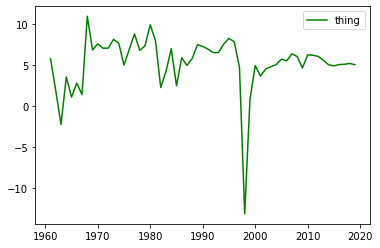

In [11]:
"""
Commented out line was the line I used for local testing. Uncommented 'data ='
should be good for universal path

universal path with help from: 

https://stackoverflow.com/questions/50119792/python-import-excel-file-using-relative-path

INDICATOR CODES:

GDP GROWTH = NY.GDP.MKTP.KD.ZG

INFLATION = NY.GDP.DEFL.KD.ZG

UNEMPLOYEMENT MALE = SL.UEM.TOTL.MA.ZS

UNEMPLOYMENT FEMALE = SL.UEM.TOTL.FE.ZS

REAL INTEREST RATE = FR.INR.RINR
"""

#data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
#                     'NY.GDP.MKTP.KD.ZG')

data = initialFormat(r'./../Indonesia Macro Dataset.xlsx', 'NY.GDP.MKTP.KD.ZG')

null_percent(data)
data.plot(color='green')
#1 Line Written by me

59


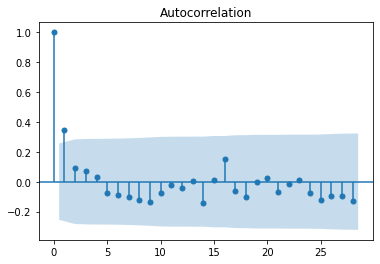

In [12]:
plot_ACF(data, 28)

#1 Line Written by me

In [13]:
#Here we split, with the train set being 80% and test set being 20%
train, test = train_test_split(data, len(data) - int(len(data) * 0.8))
train, test = train.dropna(), test.dropna()

Text(0.5, 1.0, 'GDP Split')

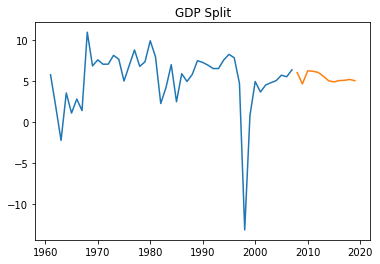

In [14]:
plot_train_test(train, test)

In [15]:
"""
This part was refactored from:

https://towardsdatascience.com/predicting-electricity-consumption-with-xgbregressor-a11b71104754

https://towardsdatascience.com/xgboost-for-time-series-forecasting-dont-use-it-blindly-9ac24dc5dfa9

These two guides are written by the same user (Michael Grogan)
"""
lookback = 1

X_train, Y_train = create_dataset(train.to_numpy(), lookback)
X_test, Y_test = create_dataset(test.to_numpy(), lookback)

In [16]:
"""
Written by me but uses function calls to xgb library
"""

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=6, learning_rate=0.3)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

RMSE:  6.176063123945592
MAPE:  44.57044378460596
MAE:  2.659117087196507
MDA:  0.2222222222222222
Mean of actual:  5.376537533197016
Scatter Index:  114.87064092479531


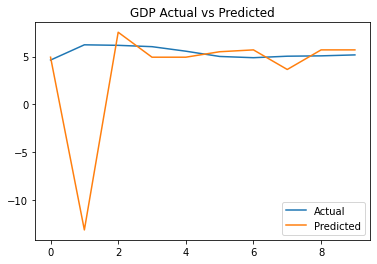

In [17]:
"""
Code written by me, however this method (line 9) was also used in a previous Introduction to AI Course I partook in,
at City University of London

Link to repository provided: 
https://github.com/LabiKSV/intro-to-ai-farhan-labi/blob/main/Linear%20Regression%20Label%20Encoder.ipynb
"""

df_compare = pd.DataFrame({'Actual' : Y_test, 'Predicted' : y_pred})
df_compare.plot(title='GDP Actual vs Predicted')
performance_metrics(Y_test, y_pred)

In [18]:
"""
Starting here is the hyperparameter optimisation for univariate forecasting

This piece of code was reused and modified from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

Fitted for my dataset
"""

def tune_n_estimator(X, y):
    hyperparam = {'max_depth': [3,6,10],
                 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
                 'n_estimators': [5,10,50,100,1000]}
    
    model = XGBRegressor()
    
    gscv = GridSearchCV(estimator=model, param_grid=hyperparam,
                       scoring='neg_mean_squared_error',
                       verbose=1)
    
    gscv.fit(X, y)
    
    print("Best hyperparam: ", gscv.best_params_)
    
#6 Lines from guide, modified by me

In [19]:
"""
Commented out because not needed. Uncomment at need.
"""

#tune_n_estimator(X_train, Y_train)

'\nCommented out because not needed. Uncomment at need.\n'

In [20]:
"""71 Lines of code, 10 import statements"""

'71 Lines of code, 10 import statements'